In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [3]:
import pandas as pd

class MnistDataset(torch.utils.data.Dataset):

    def __init__(self, file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        data = pd.read_csv(file)
        print(data.shape)
        self.x = data[data.columns[1:]].values.reshape(-1, 28,28) / 255
        self.y = data[data.columns[0]].values
        del data
        self.transform = transform

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].reshape(1,28,28).astype(np.float32), self.y[idx]

In [9]:
mnist_dataset = MnistDataset("../../239_all/239/6.Intro_to_NN/data/train.csv")

(42000, 785)


In [10]:
mnist_dataset

In [11]:
dataloader = DataLoader(mnist_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

# FACES

In [4]:
import cv2

In [5]:
import pandas as pd
import os

class FacesDataset(torch.utils.data.Dataset):

    def __init__(self, path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        files = os.listdir(path)
        data = np.zeros((len(files), 64,64))
        for i, file in enumerate(files):
            pic = cv2.resize(plt.imread(path + file), (64,64))
            if len(pic.shape) > 2:
                pic = pic[:,:,0]
            data[i] = pic.reshape(64,64)
        
        #data = pd.read_csv(file)
        print(data.shape)
        self.x = data / 255
        del data
        self.transform = transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].reshape(1,64,64).astype(np.float32)

In [188]:
faces_dataset = FacesDataset("./data/jaffe/", transform=transforms.RandomAffine(1))

(213, 64, 64)


In [189]:
faces_dataset

In [190]:
dataloader = DataLoader(faces_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

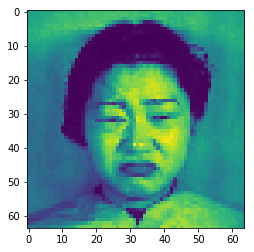

In [191]:
plt.imshow(faces_dataset.__getitem__(10)[0])

# SNOWDEN VS TRUMP

In [6]:
import cv2

In [7]:
import h5py

In [72]:
import pandas as pd
import os

class FacesDataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
    
        print(data.shape)
        self.x = data
        del data
        self.transform = transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].reshape(1,64,64).astype(np.float32)

In [73]:
def read_h5(file):
    f = h5py.File(file, 'r')
    print("Keys: %s" % f.keys())
    
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    f.close()
    
    
    return np.stack(data)[:,:,:,0].reshape(-1,1,64,64)

In [74]:
data_trump = read_h5('./data/donald.h5')
data_snowden = read_h5("./data/snowden.h5")

Keys: <KeysViewHDF5 ['data']>
Keys: <KeysViewHDF5 ['data']>


In [75]:
trump_dataset = FacesDataset(data_trump / 255)#, transform=transforms.RandomAffine(1))
snowden_dataset = FacesDataset(data_snowden / 255)#, transform=transforms.RandomAffine(1))

(85000, 1, 64, 64)
(75765, 1, 64, 64)


In [76]:
t_dataloader = DataLoader(trump_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
s_dataloader = DataLoader(snowden_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

## VAE

In [15]:
import sys
sys.path.append("./models/encoder")

In [16]:
from models.models import *

In [33]:
# enc = Encoder(np.array([28,28]), 10)
# dec = Decoder(enc.last_conv_shape, 10 )

In [34]:
#dec(enc(torch.rand(10,784))[0]).shape

In [35]:
# model = VAE().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, sigma, v = 0):
    #MSE = torch.mean((x-recon_x)**2)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    #.view(-1, 784), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = - 0.5 * torch.sum(1 + sigma - mu.pow(2) - torch.exp(sigma))
    if v:
        print(f"BCE {BCE}, KLD {KLD}")
    return BCE + KLD

In [17]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [25]:
cuda = torch.device('cuda')
with torch.cuda.device(0):
    t_vae = VAE((64,64), 100)
    s_vae = VAE((64,64), 100)
    train_vae(s_vae,s_dataloader)

Train Epoch: 0 [0/75765 (0%)]	Loss: 2873.949463
Train Epoch: 0 [80/75765 (0%)]	Loss: 8718.841797
Train Epoch: 0 [160/75765 (0%)]	Loss: 6512.064941
Train Epoch: 0 [240/75765 (0%)]	Loss: 6819.505859


KeyboardInterrupt: 

In [27]:
!nvidia-smi

Sun Jan  6 19:53:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  Off |
| 26%   36C    P0    43W / 180W |   1255MiB / 16278MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [26]:
t_vae = VAE((64,64), 100).cuda()
s_vae = VAE((64,64), 100).cuda()

In [28]:
def train_vae(vae, dataloader, max_epochs=1):
    opt = optim.Adam(vae.parameters(), lr=0.001)
    losses = []
    
    for epoch in range(max_epochs):
        for batch_idx, batch_x in enumerate(dataloader):

            opt.zero_grad()
            batch_x = batch_x#.view(-1, 784)
            out, mu, sigma = vae(batch_x.cuda())

            loss = loss_function(out, batch_x.cuda(), mu, sigma)
            loss.backward()
            opt.step()

            losses.append(loss.item() / len(batch_x))
            if batch_idx%20 == 0:
               #print(loss.item() / len(batch_x))
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(batch_x), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader),
                    loss.item() / len(batch_x)))

In [29]:
train_vae(s_vae,s_dataloader)

Train Epoch: 0 [0/75765 (0%)]	Loss: 2914.267090
Train Epoch: 0 [80/75765 (0%)]	Loss: 8323.587891
Train Epoch: 0 [160/75765 (0%)]	Loss: 20397960.000000
Train Epoch: 0 [240/75765 (0%)]	Loss: 6390.797852
Train Epoch: 0 [320/75765 (0%)]	Loss: 6568.889648
Train Epoch: 0 [400/75765 (1%)]	Loss: 6464.524902
Train Epoch: 0 [480/75765 (1%)]	Loss: 6829.412109
Train Epoch: 0 [560/75765 (1%)]	Loss: 753234.437500
Train Epoch: 0 [640/75765 (1%)]	Loss: 26256.472656
Train Epoch: 0 [720/75765 (1%)]	Loss: 165393264.000000
Train Epoch: 0 [800/75765 (1%)]	Loss: 92142080.000000
Train Epoch: 0 [880/75765 (1%)]	Loss: 21368918.000000
Train Epoch: 0 [960/75765 (1%)]	Loss: 7960.181641
Train Epoch: 0 [1040/75765 (1%)]	Loss: 9443.286133
Train Epoch: 0 [1120/75765 (1%)]	Loss: 2537346.750000
Train Epoch: 0 [1200/75765 (2%)]	Loss: 2956776.000000
Train Epoch: 0 [1280/75765 (2%)]	Loss: 14303.582031
Train Epoch: 0 [1360/75765 (2%)]	Loss: 9846.685547
Train Epoch: 0 [1440/75765 (2%)]	Loss: 10052.176758
Train Epoch: 0 [152

Train Epoch: 0 [12400/75765 (16%)]	Loss: 17605.273438
Train Epoch: 0 [12480/75765 (16%)]	Loss: 14553.555664
Train Epoch: 0 [12560/75765 (17%)]	Loss: 16368.831055
Train Epoch: 0 [12640/75765 (17%)]	Loss: 14512.213867
Train Epoch: 0 [12720/75765 (17%)]	Loss: 13429.261719
Train Epoch: 0 [12800/75765 (17%)]	Loss: 11936.620117
Train Epoch: 0 [12880/75765 (17%)]	Loss: 23346970.000000
Train Epoch: 0 [12960/75765 (17%)]	Loss: 12532.402344
Train Epoch: 0 [13040/75765 (17%)]	Loss: 12788.124023
Train Epoch: 0 [13120/75765 (17%)]	Loss: 13782.538086
Train Epoch: 0 [13200/75765 (17%)]	Loss: 20003.078125
Train Epoch: 0 [13280/75765 (18%)]	Loss: 12535.503906
Train Epoch: 0 [13360/75765 (18%)]	Loss: 17104.703125
Train Epoch: 0 [13440/75765 (18%)]	Loss: 17865.441406
Train Epoch: 0 [13520/75765 (18%)]	Loss: 13455.467773
Train Epoch: 0 [13600/75765 (18%)]	Loss: 15043.656250
Train Epoch: 0 [13680/75765 (18%)]	Loss: 16994.941406
Train Epoch: 0 [13760/75765 (18%)]	Loss: 16972.029297
Train Epoch: 0 [13840/757

KeyboardInterrupt: 

In [44]:
train_vae(t_vae,t_dataloader)

Train Epoch: 0 [0/85000 (0%)]	Loss: 2889.136719
Train Epoch: 0 [80/85000 (0%)]	Loss: 93287587840.000000
Train Epoch: 0 [160/85000 (0%)]	Loss: 487840251904.000000
Train Epoch: 0 [240/85000 (0%)]	Loss: 7306614407168.000000
Train Epoch: 0 [320/85000 (0%)]	Loss: 26367750144.000000
Train Epoch: 0 [400/85000 (0%)]	Loss: 2440686592.000000
Train Epoch: 0 [480/85000 (1%)]	Loss: 10274635776.000000
Train Epoch: 0 [560/85000 (1%)]	Loss: 20899063808.000000
Train Epoch: 0 [640/85000 (1%)]	Loss: 438477520896.000000
Train Epoch: 0 [720/85000 (1%)]	Loss: 15911988.000000
Train Epoch: 0 [800/85000 (1%)]	Loss: 42145792000.000000
Train Epoch: 0 [880/85000 (1%)]	Loss: 71500333056.000000
Train Epoch: 0 [960/85000 (1%)]	Loss: 8086091202560.000000
Train Epoch: 0 [1040/85000 (1%)]	Loss: 46104461312.000000
Train Epoch: 0 [1120/85000 (1%)]	Loss: 1912377180160.000000
Train Epoch: 0 [1200/85000 (1%)]	Loss: 276471072.000000
Train Epoch: 0 [1280/85000 (2%)]	Loss: 1005329186816.000000
Train Epoch: 0 [1360/85000 (2%)]	

Train Epoch: 0 [11440/85000 (13%)]	Loss: 38664840.000000
Train Epoch: 0 [11520/85000 (14%)]	Loss: 1131917824.000000
Train Epoch: 0 [11600/85000 (14%)]	Loss: 10202088448.000000
Train Epoch: 0 [11680/85000 (14%)]	Loss: 1431323.125000
Train Epoch: 0 [11760/85000 (14%)]	Loss: 61238884.000000
Train Epoch: 0 [11840/85000 (14%)]	Loss: 1270567552.000000
Train Epoch: 0 [11920/85000 (14%)]	Loss: 502279.093750
Train Epoch: 0 [12000/85000 (14%)]	Loss: 1749078400.000000
Train Epoch: 0 [12080/85000 (14%)]	Loss: 1640268.375000
Train Epoch: 0 [12160/85000 (14%)]	Loss: 9797817344.000000
Train Epoch: 0 [12240/85000 (14%)]	Loss: 195200958464.000000
Train Epoch: 0 [12320/85000 (14%)]	Loss: 16860026.000000
Train Epoch: 0 [12400/85000 (15%)]	Loss: 168571664.000000
Train Epoch: 0 [12480/85000 (15%)]	Loss: 18645204992.000000
Train Epoch: 0 [12560/85000 (15%)]	Loss: 79025272.000000
Train Epoch: 0 [12640/85000 (15%)]	Loss: 8857120768.000000
Train Epoch: 0 [12720/85000 (15%)]	Loss: 319123520.000000
Train Epoch: 

KeyboardInterrupt: 

In [104]:
!git commit -a -m 'pps'



*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@189cd8def068.(none)')


In [58]:
vae.dec(torch.randn(1, 10)).shape

torch.Size([1, 1, 28, 28])

In [226]:
vae.enc(batch_x)

(tensor([[  7.9019,   7.1082,   3.9043, -14.8400,  -0.8252,  -1.7435,   3.8550,
          -11.0614,  16.0926,  -2.0630]], grad_fn=<ThAddmmBackward>),
 tensor([[ -33.9994,  -48.2255, -134.0320, -394.1775, -170.5674, -283.9693,
          -308.1090, -147.7783,  -81.0785,  -21.4300]],
        grad_fn=<ThAddmmBackward>))

In [71]:
trump_dataset[0].max()

0.003921569

In [100]:
mu

tensor([[  1.1237, -13.4278,  11.4791,  -4.4557,  -8.2570,   1.3718,   1.7027,
          -0.1134,  -9.7105,   1.0357,   0.7658,  -0.2059,   5.3838,  -5.7344,
          -5.9475,  12.0044,   5.9641,  -9.3059,  -4.7703, -11.6066,   4.2497,
          -2.6147,   2.2517,   1.2008,   3.4454,  -3.5196,   9.8057, -22.5040,
          -1.7938,  -3.3910,  -5.7538,   2.0773,   4.1213,  -3.7328,   1.9381,
          -6.0099,  -3.8975,  -0.2791,   2.1858,  -4.9915,   1.8653,  -3.1885,
          -4.0782,   2.9159,  -5.5561,  -2.7083,  -2.2798,  -1.5022,   1.5509,
           0.6399, -14.7332,   0.6398,   3.5984,  -3.6653,  -4.3407,   5.0472,
           7.7239,  11.4232,  -1.9824,  -4.7321,  -0.5397,   7.1647,   1.8678,
           0.5600,  -0.3886,  -3.4058,  -2.1674, -11.2370,  -0.7521,   4.1365,
           3.9576,  -1.8182,  -7.3783,  -5.7261,  -6.3256,   3.7627,  -5.8975,
           9.8337,   7.0384,   7.8664,   4.2649,   9.1530,   1.0451,   5.8512,
           3.4694,  -2.7144,  -7.7598,   3.7801,  -1

In [101]:
s_vae.enc(torch.from_numpy(snowden_dataset.__getitem__(idx).reshape(1,1,64,64)).cuda())

(tensor([[-19.9088,   6.4232,  10.0308,   6.1199,   2.5408,   3.5764, -20.5922,
          -11.3955,   8.2345,   0.3273,  17.5398,   4.4808,   6.3360,   5.1976,
           -1.2771,   8.4091, -10.5012,  -1.3642,  -0.7087,  -3.4474,  -2.0477,
           -4.9588,   7.8920,  -2.4507,   1.9696,  -0.0781,   6.3391, -11.5957,
           -6.6656, -16.3836,   1.6265, -33.5125,  -2.6205, -22.1571,  11.4573,
            4.9692,  -5.9839, -20.6818,   8.2578,  -4.1873,   4.6844,  -6.4568,
           -8.3328,   6.1798,  -6.9231,  -4.3173,  -9.3087,   2.2738,  -0.8198,
            2.0063,  -2.0961,  12.4322,  -7.7404, -15.5030,  -8.4570,  -2.8307,
           15.6235,  -3.3649,  -9.0869, -15.6715,   2.5558, -16.6902,   6.7784,
           -8.2758,   5.9130,  -5.2669,   6.5693,   4.8926,  -0.0639,  16.1226,
            0.8691,   6.7980,  -6.8998, -13.7185,   4.3461, -28.9602,  -5.4943,
           10.6184,   9.0272, -10.1269,  19.1843,  -8.3204,  -3.6930,   2.3917,
           15.7857, -10.4562,   3.3921, 

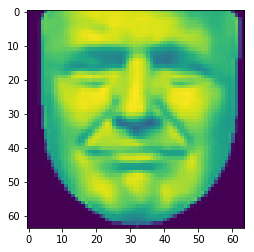

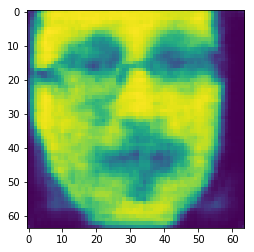

In [99]:
idx = 0
mu, logvar = t_vae.enc(torch.from_numpy(trump_dataset.__getitem__(idx).reshape(1,1,64,64)).cuda())
plt.imshow(trump_dataset.__getitem__(idx)[0])
plt.show()
plt.imshow(s_vae.dec((mu+logvar).cuda())[0][0].cpu().detach())

In [80]:
mu, logvar = t_vae.enc(torch.from_numpy(trump_dataset.__getitem__(0).reshape(1,1,64,64)).cuda())

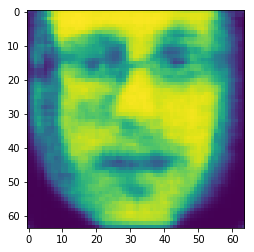

In [86]:
plt.imshow(s_vae.dec(mu.cuda())[0][0].cpu().detach())

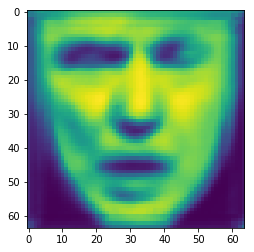

In [49]:
v = np.zeros((1,100))
v[0] += 0
v = torch.from_numpy(v).view(1,100).float().cuda()
plt.imshow(t_vae.dec(v)[0][0].cpu().detach())

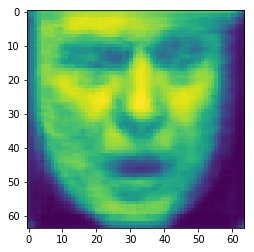

In [50]:
v = np.ones((1,100))
v[:,5] +=  10
v = torch.from_numpy(v).view(1,100).float().cuda()
plt.imshow(t_vae.dec(v)[0][0].cpu().detach())

In [4]:
## read h5

import h5py
filename = './data/faces/donald.h5'


In [5]:
def read_h5(file):
    f = h5py.File(file, 'r')
    print("Keys: %s" % f.keys())
    
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    f.close()
    
    
    return np.stack(data)[:,:,:,0].reshape(-1,1,64,64)

In [6]:
data_trump = read_h5('./data/faces/donald.h5')
data_snowden = read_h5("./data/faces/snowden.h5")

Keys: KeysView(<HDF5 file "donald.h5" (mode r)>)
Keys: KeysView(<HDF5 file "snowden.h5" (mode r)>)


In [9]:
data_trump.shape

(85000, 1, 64, 64)

In [7]:
data_snowden.shape

(75765, 1, 64, 64)